# Multibin Coupled NormSys

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyhf
import logging
logging.basicConfig(level = logging.INFO)
from pyhf import Model
def prep_data(sourcedata):
    spec =  {
        'signal': {
            'signal': {
                'data': sourcedata['signal']['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'bkg1': {
                'data': sourcedata['signal']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data':  {'lo': 0.9, 'hi': 1.1}
                    }
                ]
            },
            'bkg2': {
                'data': sourcedata['signal']['bindata']['bkg2'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data':  {'lo': 0.5, 'hi': 1.5}
                    }
                ]
            }
        },
        'control': {
            'background': {
                'data': sourcedata['control']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data': {'lo': 0.9, 'hi': 1.1}
                    }
                ]
            }
        }
    }
    pdf  = Model(spec)
    data = []
    for c in pdf.config.channel_order:
        data += sourcedata[c]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [3]:
source = {
  "channels": {
    "signal": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [105.0, 220.0],
        "bkg1":     [100.0, 100.0],
        "bkg2":     [50.0, 100.0],
        "sig":     [10.0, 35.0]
      }
    },
    "control": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [110.0, 105.0],
        "bkg1":     [100.0, 100.0]
      }
    }
  }
}



d,pdf = prep_data(source['channels'])

print (d)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.unconstrained_bestfit(d,pdf,init_pars,par_bounds)
print ('UNCON',unconpars)

conpars = pyhf.constrained_bestfit(0.0,d,pdf,init_pars,par_bounds)
print ('CONS', conpars)

pdf.expected_data(conpars)

INFO:pyhf:adding modifier coupled_normsys (1 new nuisance parameters)
INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:accepting existing normsys
INFO:pyhf:accepting existing normsys


[105.0, 220.0, 110.0, 105.0, 0]
UNCON [-0.71800968  1.4972384 ]
CONS [-0.08242659  0.        ]


array([  1.46358696e+02,   1.93582082e+02,   9.91353093e+01,
         9.91353093e+01,  -8.24265938e-02])

/home/mcf/anaconda3/lib/python3.5/site-packages/pyhf-0.0.3-py3.5.egg/pyhf/__init__.py:403: RuntimeWarning: divide by zero encountered in double_scalars


{'exp': [1.030070815690828,
  1.3534848903845373,
  1.8221856336048998,
  2.437474640200779,
  3.129496795556999],
 'obs': 2.687307803283854}

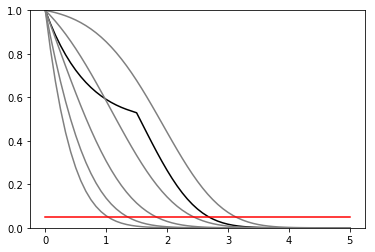

In [4]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross


pyhf.runOnePoint(1.0, d, pdf, init_pars, par_bounds)[-2:]


mutests = np.linspace(0,5,61)
tests = [pyhf.runOnePoint(muTest, d, pdf, init_pars, par_bounds)[-2:] for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)